In [3]:
import pandas as pd
import numpy as np
from sklearn.linear_model import SGDClassifier, SGDRegressor
import lightgbm as lgb
from matplotlib import pyplot as plt
import joblib
from pathlib import Path
import sqlite3

In [4]:
pd.options.display.max_rows=650

In [5]:
connection = sqlite3.connect('../data/nba.db')


df = pd.read_sql('SELECT * FROM team_stats_ewa_matchup', con=connection)
df = df.drop(columns=['index'])

connection.close()

df = df.sort_values('GAME_DATE')

df = df.dropna()

columns_to_drop = ['SEASON', 'HOME_TEAM_ABBREVIATION', 'GAME_DATE', 'GAME_ID', 'MATCHUP',
       'HOME_HOME_GAME', 'HOME_TEAM_SCORE', 'HOME_ML', 'HOME_SPREAD',
       'HOME_ATS_DIFF', 'HOME_TEAM_COVERED', 'HOME_POINT_DIFF', 'HOME_WL', 'AWAY_ML', 'AWAY_TEAM_SCORE']

train_df = df.loc[df['SEASON'] < '2021-22']
test_df = df.loc[df['SEASON'] >= '2021-22']


X_train = train_df.drop(columns=columns_to_drop)
y_train = train_df['HOME_WL']

X_test = test_df.drop(columns=columns_to_drop)
y_test = test_df['HOME_WL']

train_df.shape, test_df.shape

((9721, 641), (1234, 641))

In [6]:
def view_model_coefs(model, X_train, plot_graph = True, remove_zero_coefs=True):
    feature_names = X_train.columns
    
    try:
        coefficients = model.coef_
    except:
        print("LGBoost or XGBoost")
        coefficients = model.feature_importances_

    coef_df = pd.DataFrame({'feature_name':feature_names,
                'coef':coefficients})
    if remove_zero_coefs:
        coef_df = coef_df.loc[coef_df['coef']!=0].sort_values('coef')
    
    if plot_graph:
        top_20_features = pd.concat([coef_df.head(10), coef_df.tail(10)])
        top_20_features.plot.barh('feature_name', figsize=(6,12))
    
    return coef_df

In [7]:
filename = 'SGDRegressor_ScorePredictor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_sgd_reg = joblib.load(model_location)


In [12]:
filename = 'LGBRegressor.sav'
model_location = Path.home().joinpath('NBA_model_v1', 'models', filename)

best_lgb_reg = joblib.load(model_location)

In [21]:
best_sgd_reg.named_steps['sgd'].estimators_[0].coef_

array([ 2.76307540e+00, -3.08394120e-01,  1.04187959e-01,  5.43927609e-01,
        6.33358271e-01, -4.68852864e-02,  1.48054698e-01, -1.25338611e-01,
       -8.93894359e-03, -2.66741557e-01, -3.88495918e-02,  3.73735205e-01,
       -1.64041866e-01, -5.36976220e-02, -2.21357035e-01, -1.12909850e-01,
       -8.17882461e-02,  9.59366499e-02, -1.40774189e-01,  1.07767277e-01,
       -1.46740802e-01, -1.42195489e-01,  1.95432935e-02,  1.74727218e-01,
        1.37718372e-01, -1.52219905e-01, -1.45612326e-01, -1.32711688e-01,
       -1.67456476e-01, -1.12850932e-01,  5.60383515e-02, -5.17159033e-01,
        2.90414233e-01,  4.33068296e-01, -1.50024996e-01, -1.15595693e-01,
       -1.52098413e-01, -4.62953444e-02, -4.54789564e-01, -2.10842308e-01,
        1.64171847e-01, -4.42762925e-01, -1.33749655e-01, -3.73443482e-01,
       -7.89894709e-02,  3.89466002e-02, -4.12370038e-02, -1.39961412e-01,
        1.05427381e-01, -8.18247549e-02,  8.19924312e-05, -6.25460998e-02,
       -5.17867016e-02, -

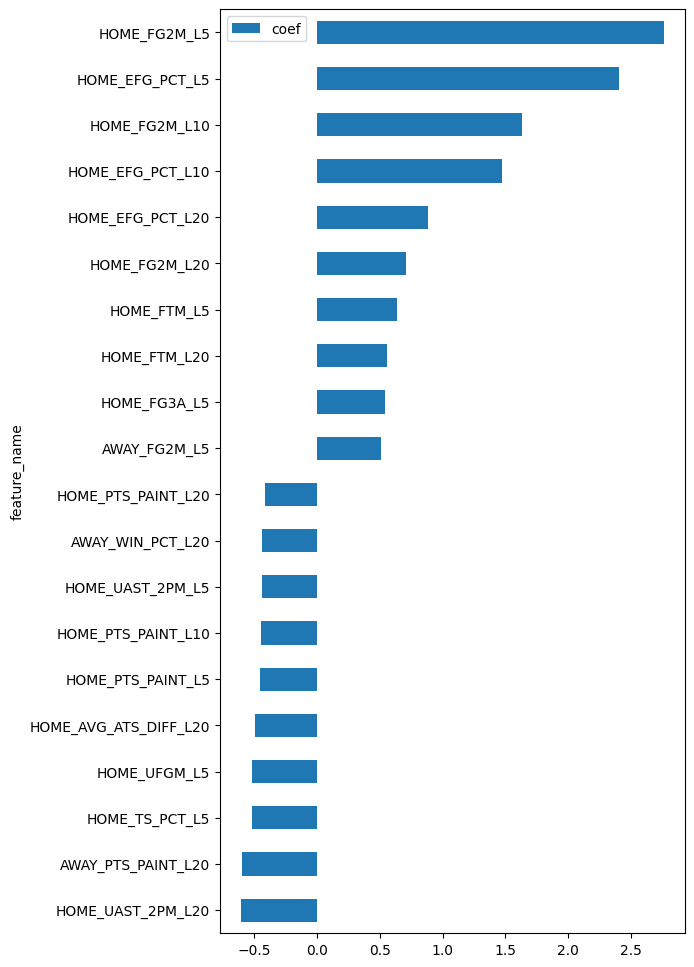

In [8]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[0], X_train)

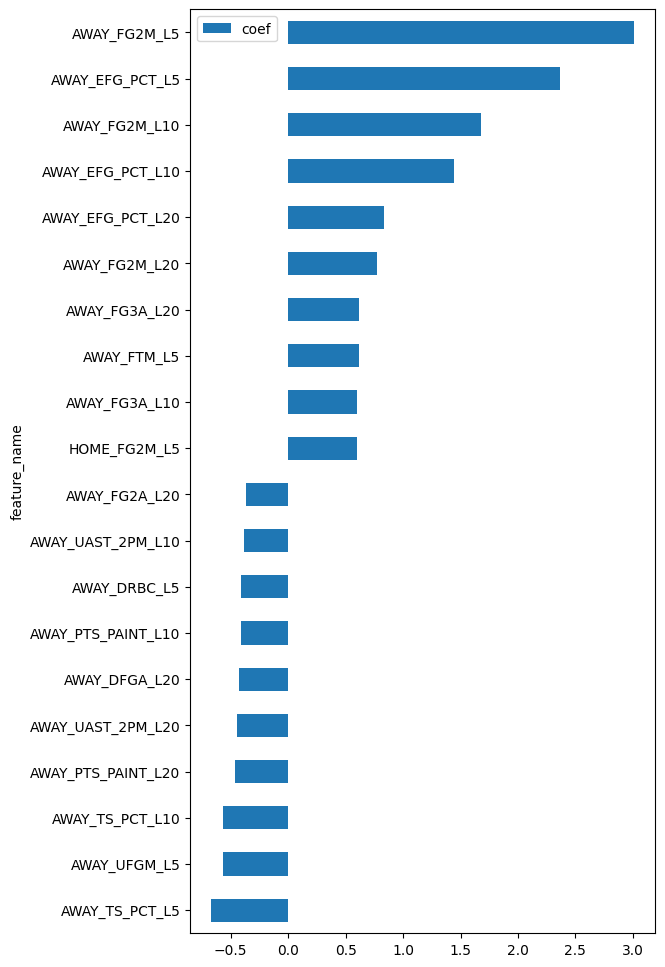

In [9]:
sgd_coef_df = view_model_coefs(best_sgd_reg.named_steps['sgd'].estimators_[1], X_train)

In [10]:
sgd_coef_df.sort_values('coef', ascending=False).head()

,feature_name,coef
313,AWAY_FG2M_L5,3.011282
410,AWAY_EFG_PCT_L5,2.364058
417,AWAY_FG2M_L10,1.675870
514,AWAY_EFG_PCT_L10,1.442820
618,AWAY_EFG_PCT_L20,0.834847


LGBoost or XGBoost


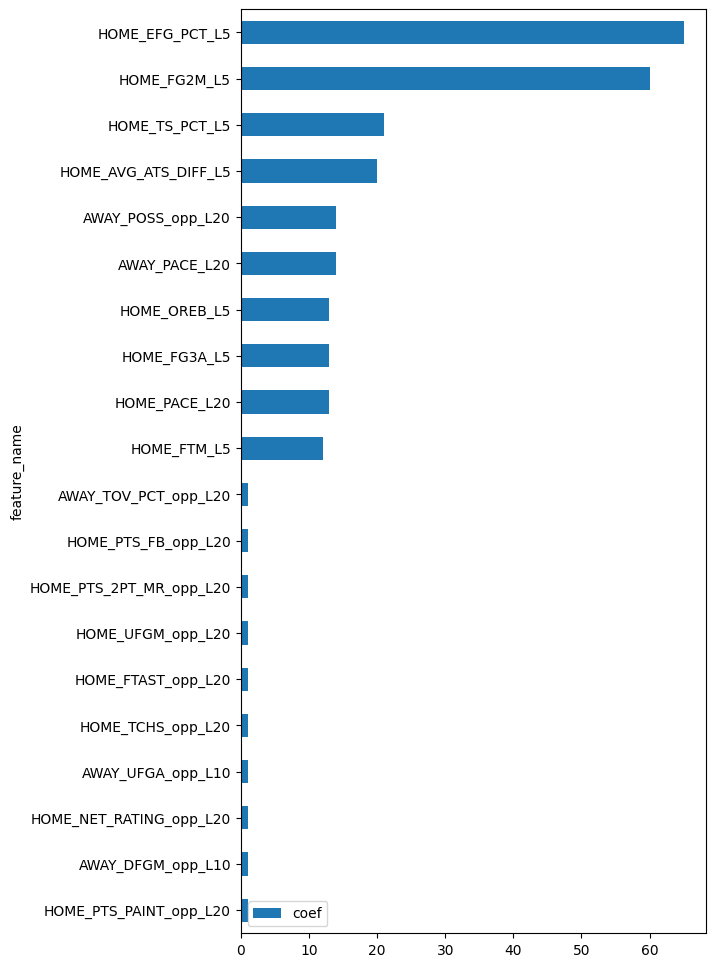

In [13]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[0], X_train)

LGBoost or XGBoost


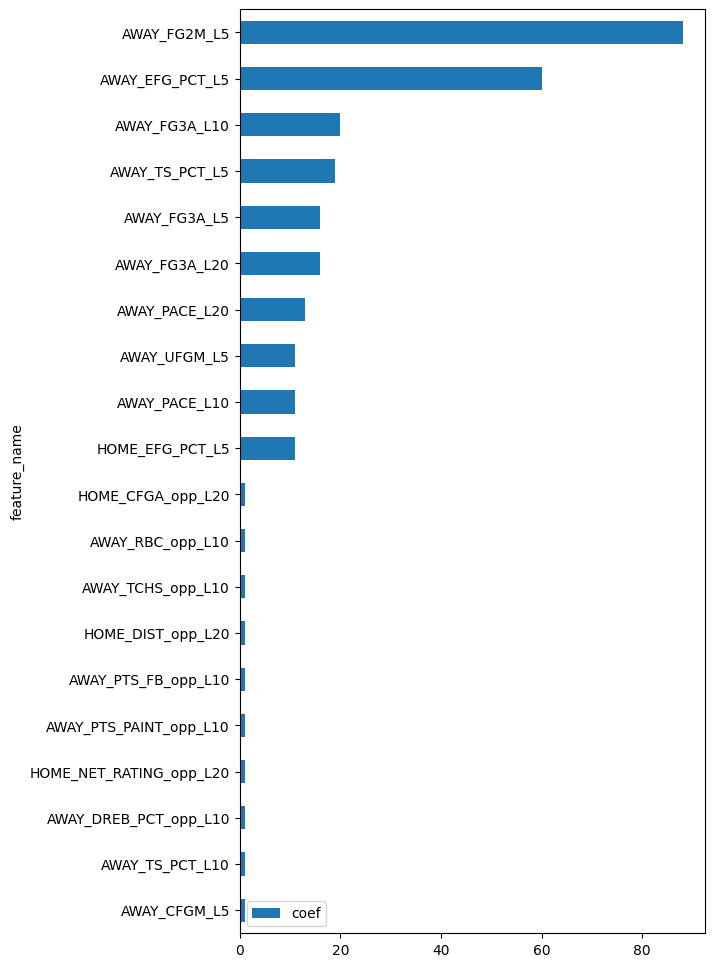

In [14]:
lgb_coef_df = view_model_coefs(best_lgb_reg.estimators_[1], X_train)